In [2]:
import cv2 as cv
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

import re

In [3]:
# Configure Jupyter to display all output lines
InteractiveShell.ast_node_interactivity = "all"

In [4]:
df_subset = pd.read_parquet(f"../data_temp/04 subset.parquet")
df_subset_filtered = df_subset[df_subset["is_in_questions"]==True]
pdf_name_i = df_subset_filtered["sha1"].iloc[0] + ".pdf"
output_path = f"../data_in/temp/md/{pdf_name_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text = f.read()

'../data_in/temp/md/0279901b645e568591ad95dac2c2bf939ef0c00d.pdf.md'

In [5]:
# Function to get text of a specific page
def get_page_text(text, page_number):
    """
    Extract text for a specified page number from the full document text.
    
    Args:
        text (str): The full document text
        page_number (int): The page number to extract
        
    Returns:
        str: The extracted text for the specified page
    """
    page_text = ""
    # Find the start and end of the page in the text
    page_marker = f"{{{page_number}}}------------------------------------------------"
    page_start = text.find(page_marker)
    if page_start != -1:
        page_start = page_start + len(page_marker)
        # Look for the next page marker or end of text
        next_page_marker = f"{{{page_number + 1}}}------------------------------------------------"
        next_page_start = text.find(next_page_marker, page_start)
        if next_page_start != -1:
            page_text = text[page_start:next_page_start]
        else:
            # If there's no next page, take all text until the end
            page_text = text[page_start:]
        return page_text
    else:
        return f"Page {page_number} is not found in the document."

# Example usage: Get text of page 91
page_91_text = get_page_text(text, 91)
print(page_91_text)



# **ACRES COMMERCIAL REALTY CORP. AND SUBSIDIARIES CONSOLIDATED BALANCE SHEETS (in thousands, except share and per share data)**

|                                                                                         |                 | December 31 |           |
|-----------------------------------------------------------------------------------------|-----------------|-------------|-----------|
|                                                                                         | 2022            |             | 2021      |
| (1)<br>ASSETS                                                                           |                 |             |           |
| Cash and cash equivalents                                                               | \$<br>66,232    | \$          | 35,500    |
| Restricted cash                                                                         | 38,579          |             | 248,431   |
| Accrued interest receivable                       

In [59]:
words_one_string = """net assets
equity
liabilities held for sale
plant and equipment
preferred stock
accrued interest payable
current tax liabilities
current portion of long-term debt
principal paydowns receivable
assets
other current liabilities
total liabilities and equity
operating lease liability
accounts payable and other liabilities
non-controlling interest
exploration and evaluation assets
other non-current assets
liability related to the sale of royalties
total current liabilities
restricted cash
issued capital
less: allowance for credit losses
inventories
deferred tax liabilities
loan receivable
contract liabilities
right of use assets
prepayments and other assets
retained earnings
liabilities and stockholders' equity
operating lease right-of-use asset
income tax receivable
other non-current liabilities
other assets
employee benefits provision
distributions in excess of earnings
deferred tax assets
short-term
total equity
lease liabilities
properties held for sale
derivative financial instruments
accumulated other comprehensive loss
prepayments
other current assets
investments in unconsolidated entities
non-controlling interests
lease receivables
borrowings
common stock
total liabilities
current tax assets
non-current assets
total stockholders' equity
cash and cash equivalents
investments in real estate
other financial assets
right-of-use assets
equity accounted investments
motor vehicles
total current assets
accrued interest receivable
reserves
deferred consideration
intangible assets
liabilities
stockholders' equity
long-term
distributions payable
current assets
other receivables
total non-current liabilities
financial liabilities
accounts payable and other accrued liabilities
trade payables and contract liabilities
non-current liabilities
accumulated losses
additional paid-in capital
other provisions
provisions
accrued compensation
current liabilities
trade receivables and contract assets
trade and other receivables
prepaid expenses
other financial liabilities
long-term debt
royalty and milestone receivable
assets held for sale
cre loans
parent interests
accrued tax liability
total non-current assets
total assets
totalassets
property and equipment
property, plant and equipment
trade and other payables
management fee payable
trade receivables and contract assetsother financial assets"""
balance_sheet_words = words_one_string.split("\n")
print(f"len(balance_sheet_words): {len(balance_sheet_words)}")

len(balance_sheet_words): 100


In [60]:
def count_phrases_by_page(text, phrases):
    # Compile the regular expression for page markers.
    # The marker matches: "{" followed by one or more digits, then "}" and at least 48 hyphens.
    page_marker = re.compile(r"\{(\d+)\}-{48,}")

    # Split the text by the page markers.
    # With the capturing group, the list will include the page number(s) interleaved with the text parts.
    parts = page_marker.split(text)

    page_counts = {}

    # Iterate over the list in pairs: page number and page text.
    for i in range(1, len(parts), 2):
        page_num = int(parts[i])
        page_text = parts[i+1] if (i+1) < len(parts) else ""
        page_text = page_text.replace("<br>", " ").replace("\n", " ")
        counts = {}
        for phrase in phrases:
            pattern = re.compile(re.escape(phrase), flags=re.IGNORECASE)
            counts[phrase] = len(pattern.findall(page_text))
        page_counts[page_num] = counts

    return page_counts

def count_numbers_on_page(text, filter_pages=None):
    """
    Count the number of numeric values on each page of the document.
    
    Args:
        text (str): The markdown text of the document
        filter_pages (list, optional): List of specific page numbers to analyze. If None, all pages are analyzed.
        
    Returns:
        dict: Dictionary mapping page numbers to the count of numbers found on that page
    """
    # Find page markers in the text
    page_markers = re.finditer(r"\{(\d+)\}-{48,}", text)
    page_numbers = []
    page_starts = []

    # Collect all page numbers and their starting positions
    for match in page_markers:
        page_numbers.append(int(match.group(1)))
        page_starts.append(match.start())

    # Add the end of the document as the last position
    page_starts.append(len(text))

    # Pattern to match numbers in various formats:
    # - Regular integers: 123, 456
    # - Numbers with commas: 1,234,567
    # - Numbers with dots as decimal separators: 123.45
    # - Numbers with spaces as thousand separators: 1 234 567
    number_pattern = r'(?<!\w)(?:(?:\d{1,3}(?:,\d{3})+|\d{1,3}(?:\s\d{3})+|\d+(?:\.\d+)?))(?!\w)'
    
    # Count numbers on each page
    page_number_counts = {}

    for i in range(len(page_numbers)):
        page_num = page_numbers[i]
        
        # Skip pages not in filter_pages if filter is provided
        if filter_pages is not None and page_num not in filter_pages:
            continue
            
        start_pos = page_starts[i]
        end_pos = page_starts[i+1] if i+1 < len(page_starts) else len(text)
        
        # Extract the page content
        page_content = text[start_pos:end_pos]
        
        # Find all numbers on the page
        numbers_found = re.findall(number_pattern, page_content)
        
        # Store the count
        page_number_counts[page_num] = len(numbers_found)

    return page_number_counts

In [64]:
for i, sha1_i in enumerate(df_subset_filtered["sha1"].iloc[1]):
    sha1_i = "4e3efdc544140b872a59e124443a64c34f356911"
    pdf_name_i = sha1_i + ".pdf"
    output_path = f"../data_in/temp/EnterpriseRAG_2025_02_markdown/{sha1_i}/{sha1_i}.md"
    with open(output_path, "r", encoding="utf-8") as f:
        text = f.read()
    res = count_phrases_by_page(text, balance_sheet_words)
    df = pd.DataFrame.from_dict(res, orient='index')
    df2 = (df > 0)*1
    number_counts = count_numbers_on_page(text)
    s_number_counts = pd.Series(number_counts)
    sums1 = df2.sum(axis=1) 
    sums2 = df2.sum(axis=1) + df2["total assets"]*10
    sums1 = sums1.sort_values(ascending=False)
    sums2 = sums2.sort_values(ascending=False)
    # Create a list of pages by interleaving the indices from sums1 and sums2
    pages_from_sums1 = sums1.index.tolist()
    pages_from_sums2 = sums2.index.tolist()
    
    # Determine the maximum length to iterate through
    max_length = max(len(pages_from_sums1), len(pages_from_sums2))
    
    # Create the interleaved list
    interleaved_pages = []
    for i in range(max_length):
        # Add page from sums1 if available
        if i < len(pages_from_sums1):
            interleaved_pages.append(pages_from_sums1[i])
        # Add page from sums2 if available
        if i < len(pages_from_sums2):
            interleaved_pages.append(pages_from_sums2[i])
    
    # Remove duplicates while preserving order
    unique_interleaved_pages = []
    for page in interleaved_pages:
        if page not in unique_interleaved_pages:
            unique_interleaved_pages.append(page)
    
    print("Interleaved pages:", unique_interleaved_pages[:5])
    
    # Use the first page from the interleaved list
    sums = sums1  # Default to sums1 for compatibility with existing code
    page = sums.idxmax()
    bs_page = get_page_text(text, page)
    print("-"*80)
    print(f"sha1_i: {sha1_i}")
    print(f"page:   {page}")
    print(bs_page)

--------------------------------------------------------------------------------
sha1_i: 4e3efdc544140b872a59e124443a64c34f356911
page:   2


Guaranty Bancshares realized strong financial results during the year. Total loans for the Company grew \$470.1 million during the year, to a record high of \$2.4 billion. Total deposits ended the year with growth of \$10.3 million and, likewise, a new record total of \$2.7 billion. One of our primary goals for 2022 was to exceed the previous year's net income, which was a tall order given that 2021 included over \$7.8 million in PPP-related extraordinary income and a reverse provision to our loan loss reserves of \$1.7 million. I'm pleased to say we achieved this goal.

The Company generated net income of \$40.4 million, compared to \$39.8 million in the prior year, a \$641,000 or a 1.6% increase. We accomplished this result even after taking a \$3.4 million provision for potential future loan losses during the last quarter of the year. We felt 

In [65]:
sums

0     0
1     0
2     6
3     0
4     2
5     0
6     2
7     0
8     5
9     2
10    0
dtype: int64

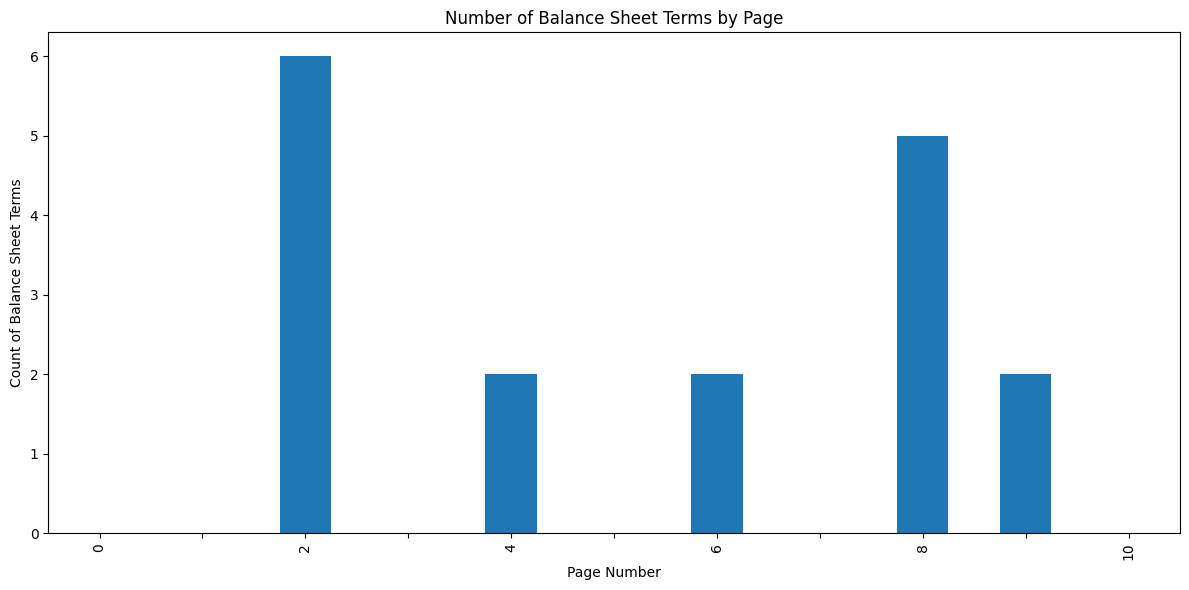

second_max: 5
max_count: 6
std_count: 2.1616492020508957
second_max: 5
snr:       2.7756585084700207
snr_second:1.2


In [66]:
# sha1_i = "c74139ce26a6f803725f5074a8a0f539abb99c09"
# pdf_name_i = sha1_i + ".pdf"
# output_path = f"../data_in/temp/EnterpriseRAG_2025_02_markdown/{sha1_i}/{sha1_i}.md"
# with open(output_path, "r", encoding="utf-8") as f:
#     text = f.read()

# res = count_phrases_by_page(text, balance_sheet_words)
# df = pd.DataFrame.from_dict(res, orient='index')
# df2 = (df > 0)*1
# sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

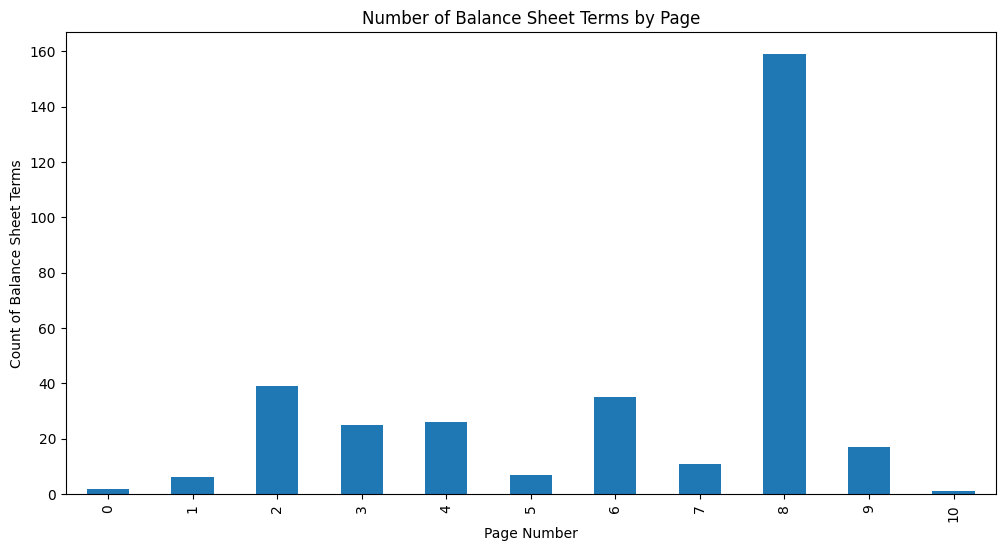

In [67]:
number_counts = count_numbers_on_page(text)
s_number_counts = pd.Series(number_counts)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = s_number_counts.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

In [70]:
sums[sums > 4]

2    6
8    5
dtype: int64

In [73]:
pages = sums[sums > 4].index.to_list()
pages

[2, 8]

In [74]:
for page in pages:
    str_page = page
    page = int(page)
    bs_page = get_page_text(text, page)
    print("-"*80)
    print(f"sha1_i: {sha1_i}")
    print(f"page:   {page}")
    print(f"key word fit: {sums[str_page]}")
    print(f"number_counts: {number_counts[page]}")
    print(bs_page)    

--------------------------------------------------------------------------------
sha1_i: 4e3efdc544140b872a59e124443a64c34f356911
page:   2
key word fit: 6
number_counts: 39


Guaranty Bancshares realized strong financial results during the year. Total loans for the Company grew \$470.1 million during the year, to a record high of \$2.4 billion. Total deposits ended the year with growth of \$10.3 million and, likewise, a new record total of \$2.7 billion. One of our primary goals for 2022 was to exceed the previous year's net income, which was a tall order given that 2021 included over \$7.8 million in PPP-related extraordinary income and a reverse provision to our loan loss reserves of \$1.7 million. I'm pleased to say we achieved this goal.

The Company generated net income of \$40.4 million, compared to \$39.8 million in the prior year, a \$641,000 or a 1.6% increase. We accomplished this result even after taking a \$3.4 million provision for potential future loan losses during the 